In [7]:
from combined_player import player_minutes_value
from html_scraper import db
from mongo_to_db import create_master_df

In [2]:
import pprint
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [12]:
pd.set_option('display.max_columns', 50)

# Master Dataframe of All Players

In [29]:
games = db.games.find()
players = db.players.find()

In [30]:
final_df = player_minutes_value(games, players)

In [31]:
final_df.head()

,player_id,player_name,club,birthday,age,foot,squad_num,height,total_minutes_played,transfer_value(sterlings),transfer_value(USD)
0,19132.0,Alexander Domínguez,Squad Club Atlético Vélez Sarsfield,"Jun 5, 1987 (31)",31,right,22.0,"1,95 m",1080.000000,£1.58m,2.01
1,27987.0,Lucas Hoyos,Squad Club Atlético Vélez Sarsfield,"Apr 29, 1989 (29)",29,right,12.0,"1,83 m",90.000000,£135k,0.17
2,30896.0,Gastón Díaz,Squad Club Atlético Vélez Sarsfield,"Mar 13, 1988 (30)",30,right,24.0,"1,75 m",896.483333,£450k,0.57
3,94225.0,Joaquín Laso,Squad Club Atlético Vélez Sarsfield,"Jul 4, 1990 (28)",28,right,6.0,"1,85 m",990.000000,£270k,0.34
4,99779.0,Luis Abram,Squad Club Atlético Vélez Sarsfield,"Feb 27, 1996 (22)",22,left,29.0,"1,80 m",1080.000000,£405k,0.51


# All Shot Data

In [8]:
games = db.games.find()
shots_df = create_master_df(games)

/Users/david/galvanize/super_liga_xg/mongo_to_db.py:69: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  final_df = pd.concat([attach_to_df, df], axis=0, ignore_index=True)
/Users/david/galvanize/super_liga_xg/dataframe_cleaner.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  input_df['is_goal'] = input_df.loc[:, 'shot_type'].isin([9, 11, 12, 13]).astype(int)


In [11]:
shots_df.head()

,game_id,player_id,shot_coord_x1,shot_coord_x2,shot_coord_y1,shot_coord_y2,shot_coord_z1,shot_coord_z2,shot_id,shot_type,...,pass_coord_y1,pass_coord_y2,pass_coord_z1,pass_coord_z2,corner_kick,shot_distance,shot_angle,assisted_shot,is_penalty_attempt,is_goal
0,448548,99779.0,6.67,0.00,1.51,-1.21,-1,0.83,22336297,11,...,29.36,-4.84,-1.0,-1.0,1.0,6.838786,12.755990,1,0,1.0
1,448548,60730.0,21.33,12.00,4.24,-0.91,-1,0.73,22336386,35,...,NaN,NaN,NaN,NaN,0.0,21.747333,11.242763,0,0,0.0
2,448548,177285.0,12.00,1.78,0.00,-3.03,-1,0.21,22336583,13,...,NaN,NaN,NaN,NaN,0.0,12.000000,0.000000,0,1,1.0
3,448548,185745.0,8.44,0.89,14.53,-6.66,-1,-1.00,22336723,33,...,3.93,19.67,-1.0,-1.0,0.0,16.803407,59.849102,1,0,0.0
4,448548,77892.0,22.22,0.44,13.92,-8.48,-1,-1.00,22336739,33,...,NaN,NaN,NaN,NaN,0.0,26.220122,32.065607,0,0,0.0


# Manual Train/Test/Split and Random Forest

In [13]:
from model_prep import create_training_df, create_test_df, create_xG_df, create_summed_xG_df, create_test_min_df, merged_dataframes

In [14]:
train_data, train_y, indices, hold_test = create_training_df(shots_df)
test_data, test_y, indices1, holdout, test = create_test_df(shots_df, hold_test)

In [15]:
print(len(holdout))
#holdout is game_id where as the other two are shot events
print(len(train_data))
len(test_data)

57
1124


740

In [16]:
from sklearn.metrics import log_loss
from sklearn.ensemble import  RandomForestClassifier

In [17]:
random_forest_model = RandomForestClassifier(n_estimators=300, max_depth=3, verbose=1)
random_forest_model.fit(train_data, train_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [18]:
p_random_forest = random_forest_model.predict_proba(test_data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished


In [19]:
random_forest_ll = log_loss(test_y, p_random_forest )
random_forest_ll

0.28690652186045973

### Calculating xG and aggregating it for each player

In [20]:
xg_df = create_xG_df(test_data, test_y, p_random_forest)
contributions = create_summed_xG_df(xg_df)

In [21]:
contributions.head()

,player_id,total_xG,total_xA,total_xG+xA,goals
0,55267.0,1.98,0.27,2.25,2.0
1,24256.0,1.94,0.44,2.38,4.0
2,16081.0,1.92,0.72,2.64,1.0
3,77919.0,1.85,0.22,2.07,1.0
4,488.0,1.57,0.34,1.91,2.0


### Calculating Minutes Played for These Games

In [24]:
from mongo_to_db import create_master_player_min_df

In [25]:
games = db.games.find()
players_minutes_df = create_master_player_min_df(games)

In [26]:
pm_df = create_test_min_df(players_minutes_df, test)

### Merge contributions with pm_df

In [28]:
subset_final_df = merged_dataframes(pm_df, contributions)

In [32]:
subset_final_df.head()

,player_name,player_id,total_xG,total_xA,total_xG+xA,goals,xG+xA/90,total_minutes_played
0,Fernando Gaibor,55267.0,1.98,0.27,2.25,2.0,0.600178,337.400000
1,Emmanuel Gigliotti,24256.0,1.94,0.44,2.38,4.0,0.528998,404.916667
2,Luis Rodríguez,16081.0,1.92,0.72,2.64,1.0,0.880000,270.000000
3,Gonzalo Martínez,77919.0,1.85,0.22,2.07,1.0,1.046629,178.000000
4,Lisandro López,488.0,1.57,0.34,1.91,2.0,0.955000,180.000000


### Merge subset_final_df with final_df to provide additional information

In [33]:
final_df.head()

,player_id,player_name,club,birthday,age,foot,squad_num,height,total_minutes_played,transfer_value(sterlings),transfer_value(USD)
0,19132.0,Alexander Domínguez,Squad Club Atlético Vélez Sarsfield,"Jun 5, 1987 (31)",31,right,22.0,"1,95 m",1080.000000,£1.58m,2.01
1,27987.0,Lucas Hoyos,Squad Club Atlético Vélez Sarsfield,"Apr 29, 1989 (29)",29,right,12.0,"1,83 m",90.000000,£135k,0.17
2,30896.0,Gastón Díaz,Squad Club Atlético Vélez Sarsfield,"Mar 13, 1988 (30)",30,right,24.0,"1,75 m",896.483333,£450k,0.57
3,94225.0,Joaquín Laso,Squad Club Atlético Vélez Sarsfield,"Jul 4, 1990 (28)",28,right,6.0,"1,85 m",990.000000,£270k,0.34
4,99779.0,Luis Abram,Squad Club Atlético Vélez Sarsfield,"Feb 27, 1996 (22)",22,left,29.0,"1,80 m",1080.000000,£405k,0.51


In [34]:
columns_to_merge = ['player_id', 'club', 'birthday', 'age', 'foot', 'squad_num', 'transfer_value(USD)']

In [35]:
final_df_part = final_df[columns_to_merge].copy()

In [37]:
subset_final_df.head()

,player_name,player_id,total_xG,total_xA,total_xG+xA,goals,xG+xA/90,total_minutes_played
0,Fernando Gaibor,55267.0,1.98,0.27,2.25,2.0,0.600178,337.400000
1,Emmanuel Gigliotti,24256.0,1.94,0.44,2.38,4.0,0.528998,404.916667
2,Luis Rodríguez,16081.0,1.92,0.72,2.64,1.0,0.880000,270.000000
3,Gonzalo Martínez,77919.0,1.85,0.22,2.07,1.0,1.046629,178.000000
4,Lisandro López,488.0,1.57,0.34,1.91,2.0,0.955000,180.000000


In [36]:
final_df_part.head()

,player_id,club,birthday,age,foot,squad_num,transfer_value(USD)
0,19132.0,Squad Club Atlético Vélez Sarsfield,"Jun 5, 1987 (31)",31,right,22.0,2.01
1,27987.0,Squad Club Atlético Vélez Sarsfield,"Apr 29, 1989 (29)",29,right,12.0,0.17
2,30896.0,Squad Club Atlético Vélez Sarsfield,"Mar 13, 1988 (30)",30,right,24.0,0.57
3,94225.0,Squad Club Atlético Vélez Sarsfield,"Jul 4, 1990 (28)",28,right,6.0,0.34
4,99779.0,Squad Club Atlético Vélez Sarsfield,"Feb 27, 1996 (22)",22,left,29.0,0.51


In [40]:
prediction_df = pd.merge(final_df_part, subset_final_df, on=['player_id'])

In [45]:
prediction_df.head()

,player_id,club,birthday,age,foot,squad_num,transfer_value(USD),player_name,total_xG,total_xA,total_xG+xA,goals,xG+xA/90,total_minutes_played
0,19132.0,Squad Club Atlético Vélez Sarsfield,"Jun 5, 1987 (31)",31,right,22.0,2.01,Alexander Domínguez,NaN,NaN,NaN,NaN,NaN,270.000000
1,27987.0,Squad Club Atlético Vélez Sarsfield,"Apr 29, 1989 (29)",29,right,12.0,0.17,Lucas Hoyos,NaN,NaN,NaN,NaN,NaN,0.000000
2,30896.0,Squad Club Atlético Vélez Sarsfield,"Mar 13, 1988 (30)",30,right,24.0,0.57,Gastón Díaz,0.29,0.16,0.45,0.0,0.229483,176.483333
3,94225.0,Squad Club Atlético Vélez Sarsfield,"Jul 4, 1990 (28)",28,right,6.0,0.34,Joaquín Laso,0.08,0.00,0.08,0.0,0.040000,180.000000
4,99779.0,Squad Club Atlético Vélez Sarsfield,"Feb 27, 1996 (22)",22,left,29.0,0.51,Luis Abram,NaN,NaN,NaN,NaN,NaN,180.000000


In [48]:
columns = ['player_id', 'player_name', 'club', 'birthday', 'age', 'foot', 'squad_num',
       'total_xG', 'total_xA', 'total_xG+xA', 'goals', 'xG+xA/90', 'transfer_value(USD)', 'total_minutes_played']

In [50]:
player_xg_df = prediction_df[columns]

### dataframe with players with xG

In [53]:
pxg = player_xg_df[player_xg_df['total_xG+xA'].notnull()]

In [59]:
pxg[(pxg['age'] < 25) & (pxg['transfer_value(USD)'] < 8) & (pxg['xG+xA/90'] > .3)]

,player_id,player_name,club,birthday,age,foot,squad_num,total_xG,total_xA,total_xG+xA,goals,xG+xA/90,transfer_value(USD),total_minutes_played
140,89000.0,Lautaro Comas,Squad Club Atlético Patronato de la Juventud C...,"Jan 15, 1995 (23)",23,-,7.0,0.41,0.24,0.65,0.0,0.424837,0.17,137.700000
157,135386.0,Leonardo Sequeira,Squad Club Atlético Belgrano,"Apr 26, 1995 (23)",23,right,26.0,1.46,0.18,1.64,1.0,0.328670,1.71,449.083333
159,95766.0,Adrián Balboa,Squad Club Atlético Belgrano,"Jan 19, 1994 (24)",24,right,11.0,0.46,0.29,0.75,0.0,0.396437,0.86,170.266667
190,172801.0,Nahuel Bustos,Squad Club Atlético Talleres,"Jul 4, 1998 (20)",20,right,7.0,0.41,0.29,0.70,0.0,0.350000,0.06,180.000000
256,114108.0,Nicolás Fernández,Squad Club Social y Deportivo Defensa y Justicia,"Feb 8, 1996 (22)",22,right,29.0,0.89,0.47,1.36,0.0,0.486938,3.43,251.366667
272,179441.0,Maximiliano Lovera,Squad Club Atlético Rosario Central,"Mar 9, 1999 (19)",19,right,34.0,0.15,0.08,0.23,0.0,1.713103,2.86,12.083333
284,103961.0,Emanuel Cecchini,Squad Club Atlético Banfield,"Dec 24, 1996 (21)",21,right,5.0,0.14,0.00,0.14,0.0,0.450536,1.71,27.966667
288,193905.0,Julián Carranza,Squad Club Atlético Banfield,"May 22, 2000 (18)",18,right,21.0,0.38,0.16,0.54,1.0,1.080000,2.29,45.000000
337,34042.0,Ricardo Noir,Squad Club Atlético Tucumán,"Mar 12, 1995 (23)",23,right,22.0,0.23,0.00,0.23,0.0,0.655409,0.46,31.583333
394,101036.0,Joel Soñora,Squad Club Atlético Talleres,"Sep 15, 1996 (22)",22,right,21.0,0.07,0.00,0.07,0.0,0.530899,0.17,11.866667


# Combining with whole dataframe

In [60]:
test_data.head()

,player_id,shot_distance,shot_angle,assisted_shot,is_penalty_attempt,is_goal,xG,xA
167,657.0,17.542158,8.919988,0,0,0.0,0.086282,0
168,209302.0,23.393354,-8.926788,0,0,0.0,0.064138,0
169,60771.0,17.290489,59.058975,0,0,0.0,0.055775,0
170,77919.0,11.563892,-1.486581,0,1,0.0,0.812601,0
171,209302.0,27.375633,16.707263,0,0,0.0,0.063981,0


In [61]:
shots_df.head()

,game_id,player_id,shot_coord_x1,shot_coord_x2,shot_coord_y1,shot_coord_y2,shot_coord_z1,shot_coord_z2,shot_id,shot_type,team_id,time_of_event(min),passed_from_id,pass_coord_x1,pass_coord_x2,pass_coord_y1,pass_coord_y2,pass_coord_z1,pass_coord_z2,corner_kick,shot_distance,shot_angle,assisted_shot,is_penalty_attempt,is_goal
0,448548,99779.0,6.67,0.00,1.51,-1.21,-1,0.83,22336297,11,20,1.033333,177285.0,0.89,12.44,29.36,-4.84,-1.0,-1.0,1.0,6.838786,12.755990,1,0,1.0
1,448548,60730.0,21.33,12.00,4.24,-0.91,-1,0.73,22336386,35,20,9.683333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,21.747333,11.242763,0,0,0.0
2,448548,177285.0,12.00,1.78,0.00,-3.03,-1,0.21,22336583,13,20,26.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,12.000000,0.000000,0,1,1.0
3,448548,185745.0,8.44,0.89,14.53,-6.66,-1,-1.00,22336723,33,20,38.883333,177285.0,22.67,6.22,3.93,19.67,-1.0,-1.0,0.0,16.803407,59.849102,1,0,0.0
4,448548,77892.0,22.22,0.44,13.92,-8.48,-1,-1.00,22336739,33,13,40.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,26.220122,32.065607,0,0,0.0


In [62]:
from model_prep import create_rf_prep

In [63]:
rf_df = create_rf_prep(shots_df)

In [65]:
p_random_forest = random_forest_model.predict_proba(rf_df)
xg_df = create_xG_df(rf_df, shots_df['is_goal'], p_random_forest)
contributions = create_summed_xG_df(xg_df)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished


In [66]:
contributions.head()

,player_id,total_xG,total_xA,total_xG+xA,goals
0,16081.0,5.42,1.59,7.01,7.0
1,101.0,4.98,1.07,6.05,5.0
2,488.0,4.70,0.93,5.63,9.0
3,24256.0,4.69,2.12,6.81,12.0
4,15113.0,3.88,0.99,4.87,3.0


In [67]:
final_df.head()

,player_id,player_name,club,birthday,age,foot,squad_num,height,total_minutes_played,transfer_value(sterlings),transfer_value(USD)
0,19132.0,Alexander Domínguez,Squad Club Atlético Vélez Sarsfield,"Jun 5, 1987 (31)",31,right,22.0,"1,95 m",1080.000000,£1.58m,2.01
1,27987.0,Lucas Hoyos,Squad Club Atlético Vélez Sarsfield,"Apr 29, 1989 (29)",29,right,12.0,"1,83 m",90.000000,£135k,0.17
2,30896.0,Gastón Díaz,Squad Club Atlético Vélez Sarsfield,"Mar 13, 1988 (30)",30,right,24.0,"1,75 m",896.483333,£450k,0.57
3,94225.0,Joaquín Laso,Squad Club Atlético Vélez Sarsfield,"Jul 4, 1990 (28)",28,right,6.0,"1,85 m",990.000000,£270k,0.34
4,99779.0,Luis Abram,Squad Club Atlético Vélez Sarsfield,"Feb 27, 1996 (22)",22,left,29.0,"1,80 m",1080.000000,£405k,0.51


In [68]:
super_liga_df = pd.merge(contributions, final_df, on=['player_id'])

In [89]:
super_liga_df['xG+xA/90'] = super_liga_df['total_xG+xA'] / (super_liga_df['total_minutes_played'] / 90 )

In [90]:
super_liga_df = super_liga_df[columns].copy()

In [91]:
#players far outplaying their xG
super_liga_df[super_liga_df['goals'] - super_liga_df['total_xG'] > 2]

,player_id,player_name,club,birthday,age,foot,squad_num,total_xG,total_xA,total_xG+xA,goals,xG+xA/90,transfer_value(USD),total_minutes_played
2,488.0,Lisandro López,Squad Racing Club,"Mar 2, 1983 (35)",35,right,15.0,4.70,0.93,5.63,9.0,0.540499,2.01,937.466667
3,24256.0,Emmanuel Gigliotti,Squad Club Atlético Independiente,"May 20, 1987 (31)",31,right,9.0,4.69,2.12,6.81,12.0,0.626708,3.43,977.966667
8,98292.0,Facundo Barceló,Squad Club Atlético Patronato de la Juventud C...,"Mar 31, 1993 (25)",25,right,31.0,3.28,1.17,4.45,6.0,0.668707,0.57,598.916667
29,39578.0,Lucas Gamba,Squad Club Atlético Huracán,"Jun 24, 1987 (31)",31,right,21.0,1.89,1.22,3.11,4.0,0.339101,2.01,825.416667
39,172801.0,Nahuel Bustos,Squad Club Atlético Talleres,"Jul 4, 1998 (20)",20,right,7.0,1.69,0.68,2.37,4.0,0.308735,0.06,690.883333
52,119431.0,Matías Rojas,Squad Club Social y Deportivo Defensa y Justicia,"Nov 3, 1995 (23)",23,left,26.0,1.45,0.60,2.05,5.0,0.259603,0.34,710.700000
108,85272.0,Rodrigo Aliendro,Squad Club Atlético Tucumán,"Feb 16, 1991 (27)",27,right,29.0,0.90,0.27,1.17,4.0,0.112414,0.86,936.716667
110,121814.0,Leonardo Heredia,Squad Club Atlético Colón,"Jan 11, 1996 (22)",22,right,21.0,0.90,0.33,1.23,3.0,0.138225,0.06,800.866667


In [92]:
#players whos xG is below their actual goals
super_liga_df[(super_liga_df['total_xG'] > super_liga_df['goals']) & (super_liga_df['goals'] > 1) & (super_liga_df['age'] < 27) ]

,player_id,player_name,club,birthday,age,foot,squad_num,total_xG,total_xA,total_xG+xA,goals,xG+xA/90,transfer_value(USD),total_minutes_played
13,135386.0,Leonardo Sequeira,Squad Club Atlético Belgrano,"Apr 26, 1995 (23)",23,right,26.0,3.01,0.25,3.26,2.0,0.322105,1.71,910.883333
14,93853.0,Franco Soldano,Squad Club Atlético Unión (Santa Fe),"Sep 14, 1994 (24)",24,right,27.0,2.81,1.45,4.26,2.0,0.361579,5.71,1060.350000
22,77919.0,Gonzalo Martínez,Squad Club Atlético River Plate,"Jun 13, 1993 (25)",25,left,10.0,2.13,0.42,2.55,2.0,0.713398,17.14,321.700000
25,87323.0,Ricardo Centurión,Squad Racing Club,"Jan 19, 1993 (25)",25,right,10.0,2.10,0.66,2.76,2.0,0.408990,5.71,607.350000


In [96]:
super_liga_df[(super_liga_df['xG+xA/90'] > 0.3) & (super_liga_df['age'] < 25)]

,player_id,player_name,club,birthday,age,foot,squad_num,total_xG,total_xA,total_xG+xA,goals,xG+xA/90,transfer_value(USD),total_minutes_played
13,135386.0,Leonardo Sequeira,Squad Club Atlético Belgrano,"Apr 26, 1995 (23)",23,right,26.0,3.01,0.25,3.26,2.0,0.322105,1.71,910.883333
14,93853.0,Franco Soldano,Squad Club Atlético Unión (Santa Fe),"Sep 14, 1994 (24)",24,right,27.0,2.81,1.45,4.26,2.0,0.361579,5.71,1060.350000
20,114108.0,Nicolás Fernández,Squad Club Social y Deportivo Defensa y Justicia,"Feb 8, 1996 (22)",22,right,29.0,2.26,1.16,3.42,3.0,0.408376,3.43,753.716667
21,172565.0,Nicolás Reniero,Squad Club Atlético San Lorenzo de Almagro,"Mar 18, 1995 (23)",23,right,15.0,2.21,1.36,3.57,3.0,0.366223,2.29,877.333333
39,172801.0,Nahuel Bustos,Squad Club Atlético Talleres,"Jul 4, 1998 (20)",20,right,7.0,1.69,0.68,2.37,4.0,0.308735,0.06,690.883333
53,103537.0,David Barbona,Squad Club Atlético Tucumán,"Feb 22, 1995 (23)",23,right,19.0,1.42,0.51,1.93,1.0,0.308033,2.29,563.900000
55,95766.0,Adrián Balboa,Squad Club Atlético Belgrano,"Jan 19, 1994 (24)",24,right,11.0,1.40,0.78,2.18,1.0,0.323949,0.86,605.650000
81,131511.0,Francisco Illarregui,Squad Asociación Atlética Argentinos Juniors,"May 6, 1997 (21)",21,-,27.0,1.13,0.72,1.85,1.0,0.430789,0.17,386.500000
88,122082.0,Franco Cristaldo,Squad Club Atlético San Martín (SJ),"Aug 15, 1996 (22)",22,right,32.0,1.06,0.83,1.89,0.0,0.345720,0.46,492.016667
98,172730.0,Nicolás Leguizamón,Squad Club Atlético Colón,"Jan 26, 1995 (23)",23,right,9.0,0.99,0.64,1.63,0.0,0.349106,1.71,420.216667


In [97]:
super_liga_df[(super_liga_df['total_xG'] > 5)]

,player_id,player_name,club,birthday,age,foot,squad_num,total_xG,total_xA,total_xG+xA,goals,xG+xA/90,transfer_value(USD),total_minutes_played
0,16081.0,Luis Rodríguez,Squad Club Atlético Tucumán,"Jan 1, 1985 (33)",33,right,7.0,5.42,1.59,7.01,7.0,0.762049,1.71,827.9


In [98]:
super_liga_df[(super_liga_df['goals'] > 5)]


,player_id,player_name,club,birthday,age,foot,squad_num,total_xG,total_xA,total_xG+xA,goals,xG+xA/90,transfer_value(USD),total_minutes_played
0,16081.0,Luis Rodríguez,Squad Club Atlético Tucumán,"Jan 1, 1985 (33)",33,right,7.0,5.42,1.59,7.01,7.0,0.762049,1.71,827.900000
2,488.0,Lisandro López,Squad Racing Club,"Mar 2, 1983 (35)",35,right,15.0,4.70,0.93,5.63,9.0,0.540499,2.01,937.466667
3,24256.0,Emmanuel Gigliotti,Squad Club Atlético Independiente,"May 20, 1987 (31)",31,right,9.0,4.69,2.12,6.81,12.0,0.626708,3.43,977.966667
8,98292.0,Facundo Barceló,Squad Club Atlético Patronato de la Juventud C...,"Mar 31, 1993 (25)",25,right,31.0,3.28,1.17,4.45,6.0,0.668707,0.57,598.916667


In [103]:
super_liga_df[(super_liga_df['xG+xA/90'] > .3) & (super_liga_df['transfer_value(USD)'] < 5) & (super_liga_df['age'] < 25)]

,player_id,player_name,club,birthday,age,foot,squad_num,total_xG,total_xA,total_xG+xA,goals,xG+xA/90,transfer_value(USD),total_minutes_played
13,135386.0,Leonardo Sequeira,Squad Club Atlético Belgrano,"Apr 26, 1995 (23)",23,right,26.0,3.01,0.25,3.26,2.0,0.322105,1.71,910.883333
20,114108.0,Nicolás Fernández,Squad Club Social y Deportivo Defensa y Justicia,"Feb 8, 1996 (22)",22,right,29.0,2.26,1.16,3.42,3.0,0.408376,3.43,753.716667
21,172565.0,Nicolás Reniero,Squad Club Atlético San Lorenzo de Almagro,"Mar 18, 1995 (23)",23,right,15.0,2.21,1.36,3.57,3.0,0.366223,2.29,877.333333
39,172801.0,Nahuel Bustos,Squad Club Atlético Talleres,"Jul 4, 1998 (20)",20,right,7.0,1.69,0.68,2.37,4.0,0.308735,0.06,690.883333
53,103537.0,David Barbona,Squad Club Atlético Tucumán,"Feb 22, 1995 (23)",23,right,19.0,1.42,0.51,1.93,1.0,0.308033,2.29,563.900000
55,95766.0,Adrián Balboa,Squad Club Atlético Belgrano,"Jan 19, 1994 (24)",24,right,11.0,1.40,0.78,2.18,1.0,0.323949,0.86,605.650000
81,131511.0,Francisco Illarregui,Squad Asociación Atlética Argentinos Juniors,"May 6, 1997 (21)",21,-,27.0,1.13,0.72,1.85,1.0,0.430789,0.17,386.500000
88,122082.0,Franco Cristaldo,Squad Club Atlético San Martín (SJ),"Aug 15, 1996 (22)",22,right,32.0,1.06,0.83,1.89,0.0,0.345720,0.46,492.016667
98,172730.0,Nicolás Leguizamón,Squad Club Atlético Colón,"Jan 26, 1995 (23)",23,right,9.0,0.99,0.64,1.63,0.0,0.349106,1.71,420.216667
151,184545.0,Jan Carlos Hurtado,Squad Club de Gimnasia y Esgrima La Plata,"Mar 5, 2000 (18)",18,right,17.0,0.69,0.41,1.10,0.0,0.408079,0.40,242.600000


In [100]:
super_liga_df[(super_liga_df['transfer_value(USD)'] > 5)]

,player_id,player_name,club,birthday,age,foot,squad_num,total_xG,total_xA,total_xG+xA,goals,xG+xA/90,transfer_value(USD),total_minutes_played
11,31939.0,Santiago García,Squad Club Deportivo Godoy Cruz Antonio Tomba,"Sep 14, 1990 (28)",28,right,18.0,3.03,0.97,4.00,3.0,0.356359,6.86,1010.216667
14,93853.0,Franco Soldano,Squad Club Atlético Unión (Santa Fe),"Sep 14, 1994 (24)",24,right,27.0,2.81,1.45,4.26,2.0,0.361579,5.71,1060.350000
22,77919.0,Gonzalo Martínez,Squad Club Atlético River Plate,"Jun 13, 1993 (25)",25,left,10.0,2.13,0.42,2.55,2.0,0.713398,17.14,321.700000
24,55210.0,Nicolás Blandi,Squad Club Atlético San Lorenzo de Almagro,"Jan 13, 1990 (28)",28,right,9.0,2.10,0.87,2.97,4.0,0.632039,6.29,422.916667
25,87323.0,Ricardo Centurión,Squad Racing Club,"Jan 19, 1993 (25)",25,right,10.0,2.10,0.66,2.76,2.0,0.408990,5.71,607.350000
32,43746.0,Edwin Cardona,Squad Club Atlético Boca Juniors,"Dec 8, 1992 (25)",25,right,10.0,1.82,0.33,2.15,2.0,0.302399,6.29,639.883333
34,177285.0,Matías Vargas,Squad Club Atlético Vélez Sarsfield,"May 8, 1997 (21)",21,right,26.0,1.79,0.42,2.21,2.0,0.194099,10.29,1024.733333
63,28126.0,Lucas Pratto,Squad Club Atlético River Plate,"Jun 4, 1988 (30)",30,right,27.0,1.31,0.64,1.95,0.0,0.242593,6.86,723.433333
76,2439.0,Juan Fernando Quintero,Squad Club Atlético River Plate,"Jan 18, 1993 (25)",25,left,8.0,1.15,0.83,1.98,1.0,0.387630,7.43,459.716667
82,111421.0,Cristian Pavón,Squad Club Atlético Boca Juniors,"Jan 21, 1996 (22)",22,right,7.0,1.12,0.52,1.64,2.0,0.266458,22.86,553.933333


(0, 20)

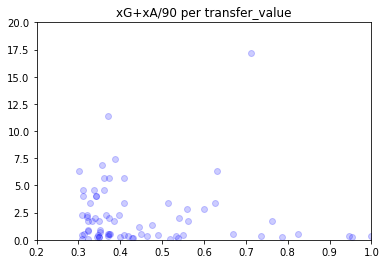

In [114]:
fig, ax = plt.subplots()
ax.scatter(super_liga_df[super_liga_df['xG+xA/90'] > .3]['xG+xA/90'], super_liga_df[super_liga_df['xG+xA/90'] > .3]['transfer_value(USD)'], alpha=0.2, color='blue')
ax.set_title('xG+xA/90 per transfer_value')
ax.set_xlim([0.2, 1])
ax.set_ylim([0, 20])

In [131]:
over_point_3 = super_liga_df[(super_liga_df['xG+xA/90'] > .3) & (super_liga_df['total_minutes_played'] > 300) & (super_liga_df['age'] < 27)].copy()
xg_xa = super_liga_df[(super_liga_df['total_xG+xA'] > 4) & (super_liga_df['total_minutes_played'] > 300) & (super_liga_df['age'] < 27)].copy()

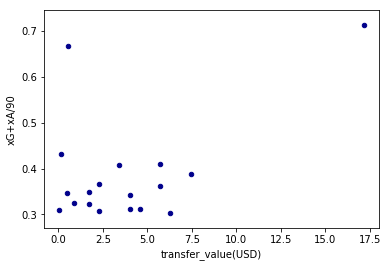

In [126]:
ax1 = over_point_3.plot.scatter(x='transfer_value(USD)', y='xG+xA/90', c='DarkBlue')

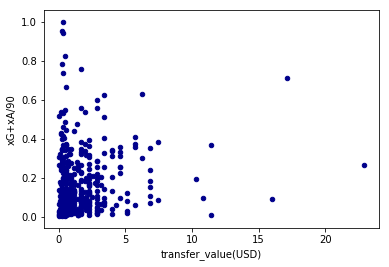

In [129]:
ax1 = super_liga_df.plot.scatter(x='transfer_value(USD)', y='xG+xA/90', c='DarkBlue')

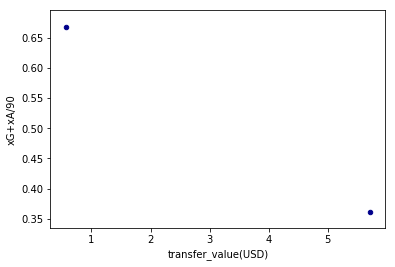

In [132]:
ax1 = xg_xa.plot.scatter(x='transfer_value(USD)', y='xG+xA/90', c='DarkBlue')

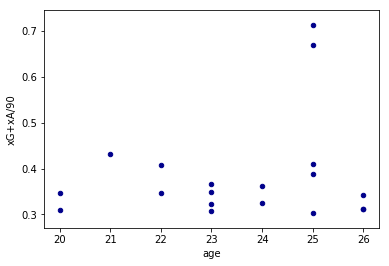

In [127]:
ax1 = over_point_3.plot.scatter(x='age', y='xG+xA/90', c='DarkBlue')

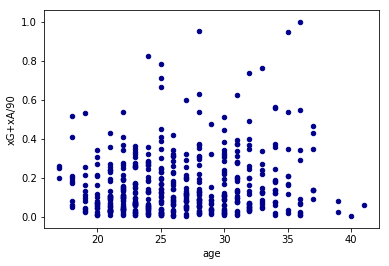

In [130]:
ax1 = super_liga_df.plot.scatter(x='age', y='xG+xA/90', c='DarkBlue')

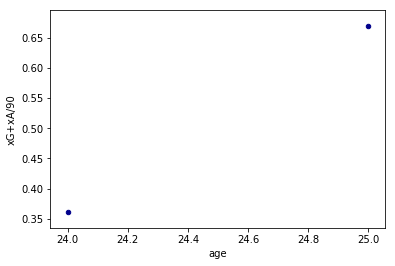

In [133]:
ax1 = xg_xa.plot.scatter(x='age', y='xG+xA/90', c='DarkBlue')